# Explore Microbe Community
> Gati Aher, SUM2021

Process Data
* import data from csv
* clean data by removing negligible / bad OTUs
* standardize data to relative abundances
* save data

Explore Data
* visualize the OTUs abundances in the original community
* perform alpha diversity analysis on the original community
    * analyze variety of OTUs
* perform beta diversity analysis to compare the effects of perturbations
    * analyze compositional shift of OTUs with PCoA on Bray-Curtis dissimlarity matrix

To download notebook as pdf, follow: https://towardsdatascience.com/jupyter-notebook-to-pdf-in-a-few-lines-3c48d68a7a63

## TODO
* TODO: taxonomy
    * get taxonomy file and do analysis at multiple levels
    * figure out what OTUs to condense (based on phylogenetic / dendogram analysis)
* TODO: alpha and beta diversity real statistical analysis
    * figure out how to do multiple corrections for factors?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

## Set Up Consistent Styling

*Key:*
- Shape indicates current carbon source
- Color indicates carbon series
- Marker Edge Width indicates day
- Marker Color indicates transfer series

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
map_carbon_shapes = {
    "C0C": "o",
    "C": "o",
    "G": "s",
    "M": "^",
}

def_marker_size = 10

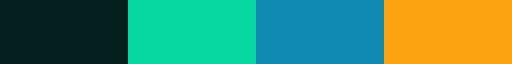

In [4]:
def_color = "#041F1E"
def_line_color = "#707070"

colors = [
    "#041F1E", # original community 
    "#06D6A0", # cellulose
    "#118AB2", # glucose
    "#FCA311", # malate
]
map_carbon_colors = {
    "C0C": colors[0],
    "C": colors[1],
    "G": colors[2],
    "M": colors[3],
}
cmap = ListedColormap(colors, name="carbon")
cmap

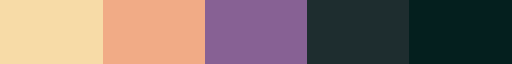

In [5]:
map_days_widths = {
    "C0C": 0,
    "3": 1,
    "5": 2,
    "7": 3,
    "10": 4,
    "20": 5,
}

colors_days = [
    "#F7DBA7", # 3
    "#F1AB86", # 5
    "#876194", # 7
    "#1E2D2F", # 10
    "#041F1E", # 20
]

map_days_colors = {
    "3": colors_days[0],
    "5": colors_days[1],
    "7": colors_days[2],
    "10": colors_days[3],
    "20": colors_days[4],
}

cmap_days = ListedColormap(colors_days, name="days")
cmap_days

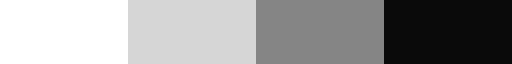

In [6]:
colors_transfers = [
    "#FFFFFF", # C0
    "#D6D6D6", # 1
    "#858585", # 2
    "#0A0A0A", # 3
]

map_transfers_colors = {
    "C0C": colors_transfers[0],
    "1": colors_transfers[1],
    "2": colors_transfers[2],
    "3": colors_transfers[3],
}

cmap_transfers = ListedColormap(colors_transfers, name="transfers")
cmap_transfers

## Process Data

### Import Data

We are working with three files:
* `<counts>.csv`: OTUs x sample
* `<annotations>.csv`: sample x variables
* `<taxonomy>.csv`: OTUs x taxonomy (TODO: don't have this)

OTUs and samples must be in the same order for all files

In [7]:
df_counts = pd.read_csv("data/FCF_master.csv", index_col=0).T
df_annotations_from_file = pd.read_csv("data/FCF_annotations.csv", index_col=0) # these aren't in the right order

In [8]:
print("df_counts.shape", df_counts.shape)
df_counts

df_counts.shape (87, 153)


opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C            18304                         16452                  9817   
1C3A           19239                          4060                 13664   
1C3B           34155                          6121                 19194   
1C5A           16237                          1967                 24640   
1C5B           23247                          6002                 16356   
...              ...                           ...                   ...   
3G7A           25593                           319                  3256   
3G7B           36316                           109                  3496   
3G7C           34948                           136                  4123   
3G10A          17610                           250                 18156   
3G10B          16218                            86                 32377   

       rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                          9279              6578              6400   
1C3A                         9191               902              1891   
1C3B                        13838              1395              3117   
1C5A                         8188               720              1520   
1C5B                        16142              1381              4462   
...                           ...               ...               ...   
3G7A                        11598             10247             69747   
3G7B                         7593              9236             40432   
3G7C                         9157             12384             40225   
3G10A                       16920              8832             72267   
3G10B                        7254              8338             38665   

       pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                      5409        4521                      3913   
1C3A                     3647        2798                      1163   
1C3B                     4828        3858                      1357   
1C5A                     2641        2308                      2046   
1C5B                     6110        4695                      3101   
...                       ...         ...                       ...   
3G7A                    28315         891                      7625   
3G7B                    30320         703                      3922   
3G7C                    28382         721                      4594   
3G10A                   27647        1603                      9659   
3G10B                   16342         766                      2289   

       spirochaeta spp.  ...  bosea spp.  corynebacterium durum  \
C0C                1958  ...           0                      0   
1C3A                257  ...           0                      0   
1C3B                221  ...           0                      0   
1C5A                265  ...           0                      0   
1C5B                605  ...           0                      1   
...                 ...  ...         ...                    ...   
3G7A                 15  ...           0                      0   
3G7B                 15  ...           0                      1   
3G7C                 16  ...           0                      0   
3G10A                 1  ...           0                      0   
3G10B                59  ...           0                      0   

       rubrivivax gelatinosus  anaerococcus hydrogenalis  globicatella spp.  \
C0C                         0                          0                  0   
1C3A                        0                          0                  0   
1C3B                        1                          0                  0   
1C5A                        1                          0                  0   
1C5B                        0                          0                  0   
...                       ...                        ...                ...   
3G7A  

In [9]:
print("df_annotations_from_file.shape", df_annotations_from_file.shape)
df_annotations_from_file.head()

df_annotations_from_file.shape (87, 3)


series       food  day
C0C      C0  cellulose   10
1C3A     1C  cellulose    3
1C3B     1C  cellulose    3
1C5A     1C  cellulose    5
1C5B     1C  cellulose    5

In [10]:
df_annotations_from_file.index == df_counts.index # these aren't in the right order

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [11]:
# Build Correct Annotations File
# columns: index series carbon transfer day
df_annotations = pd.DataFrame(index=df_counts.index)
ann_series = []
ann_carbon = []
ann_transfer = []
ann_group = []
ann_day = list(map(str, df_annotations_from_file["day"].values))

for i in df_counts.index:
    # series
    if i == "C0C":
        ann_series.append("C0C")
    else:
        ann_series.append(i[1])
    # carbon
    if i == "C0C":
        ann_carbon.append("C0C")
    elif df_annotations_from_file.loc[i, "food"] == "cellulose":
        ann_carbon.append("C")
    elif df_annotations_from_file.loc[i, "food"] == "glucose":
        ann_carbon.append("G")
    elif df_annotations_from_file.loc[i, "food"] == "malate":
        ann_carbon.append("M")
    else:
        ann_carbon.append("X")
    # transfer
    if i == "C0C":
        ann_transfer.append("C0C")
    else:
        ann_transfer.append(i[0])
    # group
    if i == "C0C":
        ann_group.append("C0C")
    else:
        ann_group.append(i[0:2])

df_annotations["group"] = ann_group
df_annotations["series"] = ann_series
df_annotations["carbon"] = ann_carbon
df_annotations["transfer"] = ann_transfer
df_annotations["day"] = ann_day

df_annotations

group series carbon transfer day
C0C     C0C    C0C    C0C      C0C  10
1C3A     1C      C      C        1   3
1C3B     1C      C      C        1   3
1C5A     1C      C      C        1   5
1C5B     1C      C      C        1   5
...     ...    ...    ...      ...  ..
3G7A     3G      G      C        3   7
3G7B     3G      G      C        3   7
3G7C     3G      G      C        3   7
3G10A    3G      G      C        3  10
3G10B    3G      G      C        3  10

[87 rows x 5 columns]

In [12]:
# Groups
groups = set(ann_group)
groups

{'1C', '1G', '1M', '2C', '2G', '2M', '3G', '3M', 'C0C'}

### Remove noisy data (OTUs that do not appear consistently)

* NOTE: 3G10C was removed because it might be a wrongly labeled result
* remove OTUs with less than total threshold read counts across all samples
* remove OTUs that don't occur in enough samples
* remove OTUs not in original sample (and check that they aren't very important)

In [13]:
# remove OTUs with less than threshold read counts across all samples
threshold = 5
too_low_read_counts = df_counts.columns[df_counts.sum(axis=0) < threshold]
# --- what OTUs have too low read counts?
print("Throw out OTUs with low read counts:", too_low_read_counts, "length:", len(too_low_read_counts))
df_too_low_read_counts = df_counts[too_low_read_counts]
print(df_too_low_read_counts.sum(axis=0).sort_values(ascending=False))
df_counts = df_counts.drop(too_low_read_counts, axis=1)

Throw out OTUs with low read counts: Index(['delftia sp.', 'methylobacillus sp.', 'rhodobacter capsulatus',
       'rubrivivax gelatinosus', 'anaerococcus hydrogenalis',
       'globicatella spp.', 'finegoldia magna', 'dietzia spp.',
       'granulicatella elegans', 'actinomyces marimammalium',
       'veillonella dispar'],
      dtype='object') length: 11
granulicatella elegans       4
dietzia spp.                 4
finegoldia magna             4
globicatella spp.            4
anaerococcus hydrogenalis    4
rubrivivax gelatinosus       4
delftia sp.                  4
veillonella dispar           3
actinomyces marimammalium    3
rhodobacter capsulatus       3
methylobacillus sp.          3
dtype: int64


In [14]:
# remove OTUs that don't appear in enough samples
threshold = 85 # have this many non-appearances out of 87 samples
num_zeros = (df_counts == 0).sum(axis=0) # count zeros in each column
too_few_appearances = df_counts.columns[num_zeros > threshold]
# --- what OTUs appear too infrequently?
print("Throw out OTUs with low appearance:", too_few_appearances, "length:", len(too_few_appearances))
df_too_few_appearances = df_counts[too_few_appearances]
print(df_too_few_appearances.sum(axis=0).sort_values(ascending=False))
df_counts = df_counts.drop(too_few_appearances, axis=1)

Throw out OTUs with low appearance: Index([], dtype='object') length: 0
Series([], dtype: float64)


In [15]:
# # remove OTUs not in original sample
# threshold = 1
# not_in_original = df_counts.columns[df_counts.loc['C0C'] < threshold]
# # --- what OTUs are not in original sample?
# print("Throw out OTUs that were not in origianl C0C community:", not_in_original, "length:", len(not_in_original))
# df_not_in_original = df_counts[not_in_original]
# print(df_not_in_original.sum(axis=0).sort_values(ascending=False))
# df_counts = df_counts.drop(not_in_original, axis=1)

In [16]:
df_counts

opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C            18304                         16452                  9817   
1C3A           19239                          4060                 13664   
1C3B           34155                          6121                 19194   
1C5A           16237                          1967                 24640   
1C5B           23247                          6002                 16356   
...              ...                           ...                   ...   
3G7A           25593                           319                  3256   
3G7B           36316                           109                  3496   
3G7C           34948                           136                  4123   
3G10A          17610                           250                 18156   
3G10B          16218                            86                 32377   

       rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                          9279              6578              6400   
1C3A                         9191               902              1891   
1C3B                        13838              1395              3117   
1C5A                         8188               720              1520   
1C5B                        16142              1381              4462   
...                           ...               ...               ...   
3G7A                        11598             10247             69747   
3G7B                         7593              9236             40432   
3G7C                         9157             12384             40225   
3G10A                       16920              8832             72267   
3G10B                        7254              8338             38665   

       pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                      5409        4521                      3913   
1C3A                     3647        2798                      1163   
1C3B                     4828        3858                      1357   
1C5A                     2641        2308                      2046   
1C5B                     6110        4695                      3101   
...                       ...         ...                       ...   
3G7A                    28315         891                      7625   
3G7B                    30320         703                      3922   
3G7C                    28382         721                      4594   
3G10A                   27647        1603                      9659   
3G10B                   16342         766                      2289   

       spirochaeta spp.  ...  burkholderia ubonensis  aeromonas spp.  \
C0C                1958  ...                       0               0   
1C3A                257  ...                       1               0   
1C3B                221  ...                       0               1   
1C5A                265  ...                       0               0   
1C5B                605  ...                       0               0   
...                 ...  ...                     ...             ...   
3G7A                 15  ...                       0               0   
3G7B                 15  ...                       0               0   
3G7C                 16  ...                       0               0   
3G10A                 1  ...                       0               0   
3G10B                59  ...                       0               0   

       methylocystis sp.  corynebacterium tuberculostearicum  \
C0C                    0                                   0   
1C3A                   0                                   0   
1C3B                   0                                   0   
1C5A                   0                                   0   
1C5B                   0                                   0   
...                  ...                                 ...   
3G7A                   0                           

### Standardize Data

Transform absolute counts to relative abundances.
Relative counts for a sample should add up to 1. Do this by dividing counts in each sample by total counts in sample.

In [17]:
df_counts_rel = df_counts.div(df_counts.sum(axis=1), axis=0)
df_counts_rel.head()

opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C        0.207686                      0.186672              0.111388   
1C3A       0.266982                      0.056341              0.189617   
1C3B       0.290486                      0.052059              0.163243   
1C5A       0.194118                      0.023516              0.294578   
1C5B       0.187871                      0.048505              0.132181   

      rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                     0.105284          0.074637          0.072618   
1C3A                    0.127545          0.012517          0.026242   
1C3B                    0.117691          0.011864          0.026510   
1C5A                    0.097890          0.008608          0.018172   
1C5B                    0.130452          0.011161          0.036060   

      pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                 0.061373    0.051297                  0.044399   
1C3A                0.050610    0.038828                  0.016139   
1C3B                0.041062    0.032812                  0.011541   
1C5A                0.031574    0.027593                  0.024461   
1C5B                0.049378    0.037943                  0.025061   

      spirochaeta spp.  ...  burkholderia ubonensis  aeromonas spp.  \
C0C           0.022216  ...                0.000000        0.000000   
1C3A          0.003566  ...                0.000014        0.000000   
1C3B          0.001880  ...                0.000000        0.000009   
1C5A          0.003168  ...                0.000000        0.000000   
1C5B          0.004889  ...                0.000000        0.000000   

      methylocystis sp.  corynebacterium tuberculostearicum  \
C0C                 0.0                                 0.0   
1C3A                0.0                                 0.0   
1C3B                0.0                                 0.0   
1C5A                0.0                                 0.0   
1C5B                0.0                                 0.0   

      sphingomonas faeni  prevotella nanceiensis  lactobacillus helveticus  \
C0C                  0.0                     0.0                       0.0   
1C3A                 0.0                     0.0                       0.0   
1C3B                 0.0                     0.0                       0.0   
1C5A                 0.0                     0.0                       0.0   
1C5B                 0.0                     0.0                       0.0   

      bacillus thermoamylovorans  bosea spp.  corynebacterium durum  
C0C                          0.0         0.0               0.000000  
1C3A                         0.0         0.0               0.000000  
1C3B                         0.0         0.0               0.000000  
1C5A                         0.0         0.0               0.000000  
1C5B                         0.0         0.0               0.000008  

[5 rows x 142 columns]

In [18]:
# check that samples sum to 1
df_counts_rel.sum(axis=1)

C0C      1.0
1C3A     1.0
1C3B     1.0
1C5A     1.0
1C5B     1.0
        ... 
3G7A     1.0
3G7B     1.0
3G7C     1.0
3G10A    1.0
3G10B    1.0
Length: 87, dtype: float64

In [19]:
# log relative counts
df_log_counts_rel = pd.DataFrame()
min_a = df_counts_rel.min()
min_a = min_a[min_a != 0]
min_val = np.min(min_a)
print("min_val", min_val)

for column in df_counts_rel.columns:
    try:
        df_log_counts_rel[column] = np.log10(df_counts_rel[column] + min_val/2) # log transform
    except (ValueError, AttributeError):
        pass

df_log_counts_rel

min_val 1.3626577276319733e-05


opitutus spp.  paludibacter propionicigenes  magnetospirillum sp.  \
C0C        -0.682578                     -0.728904             -0.953133   
1C3A       -0.573507                     -1.249122             -0.722107   
1C3B       -0.536865                     -1.283451             -0.787146   
1C5A       -0.711919                     -1.628510             -0.530789   
1C5B       -0.726124                     -1.314150             -0.878807   
...              ...                           ...                   ...   
3G7A       -0.840234                     -2.742945             -1.735530   
3G7B       -0.606137                     -3.124857             -1.622551   
3G7C       -0.641747                     -3.048323             -1.569859   
3G10A      -1.029195                     -2.874823             -1.015936   
3G10B      -0.919939                     -3.190846             -0.619712   

       rhodopseudomonas palustris  acetobacter spp.  bacteroides spp.  \
C0C                     -0.977609         -1.127005         -1.138918   
1C3A                    -0.894314         -1.902257         -1.580896   
1C3B                    -0.929231         -1.925506         -1.576481   
1C5A                    -1.009232         -2.064764         -1.740434   
1C5B                    -0.884527         -1.952048         -1.442895   
...                           ...               ...               ...   
3G7A                    -1.183947         -1.237728         -0.404842   
3G7B                    -1.285776         -1.200716         -0.559511   
3G7C                    -1.223380         -1.092285         -0.580675   
3G10A                   -1.046553         -1.328864         -0.416039   
3G10B                   -1.269328         -1.208851         -0.542632   

       pleomorphomonas oryzae  afipia sp.  rhodoblastus acidophilus  \
C0C                 -1.211973   -1.289846                 -1.352562   
1C3A                -1.295706   -1.410776                 -1.791937   
1C3B                -1.386490   -1.483877                 -1.937494   
1C5A                -1.500578   -1.559097                 -1.611413   
1C5B                -1.306405   -1.420793                 -1.600887   
...                       ...         ...                       ...   
3G7A                -0.796340   -2.297910                 -1.366067   
3G7B                -0.684503   -2.318674                 -1.572628   
3G7C                -0.732123   -2.326619                 -1.522893   
3G10A               -0.833318   -2.069705                 -1.289997   
3G10B               -0.916631   -2.245211                 -1.770140   

       spirochaeta spp.  ...  burkholderia ubonensis  aeromonas spp.  \
C0C           -1.653193  ...               -5.166643       -5.166643   
1C3A          -2.446938  ...               -4.684231       -5.166643   
1C3B          -2.724366  ...               -5.166643       -4.814792   
1C5A          -2.498261  ...               -5.166643       -5.166643   
1C5B          -2.310146  ...               -5.166643       -5.166643   
...                 ...  ...                     ...             ...   
3G7A          -4.038671  ...               -5.166643       -5.166643   
3G7B          -3.962151  ...               -5.166643       -5.166643   
3G7C          -3.953621  ...               -5.166643       -5.166643   
3G10A         -4.916415  ...               -5.166643       -5.166643   
3G10B         -3.352396  ...               -5.166643       -5.166643   

       methylocystis sp.  corynebacterium tuberculostearicum  \
C0C            -5.166643                           -5.166643   
1C3A           -5.166643                           -5.166643   
1C3B           -5.166643                           -5.166643   
1C5A           -5.166643                           -5.166643   
1C5B           -5.166643                           -5.166643   
...                  ...                                 ...   
3G7A           -5.166643                           

### Save Data
Uncomment to save cleaned relative counts

In [20]:
# df_counts_rel.to_csv("data/FCF_relative_counts.csv")
# df_log_counts_rel.to_csv("data/FCF_relative_counts_log_transform.csv")
# df_annotations.to_csv("data/FCF_annotations_corrected.csv")
print("df_counts_rel.values.shape", df_counts_rel.values.shape)
print("df_log_counts_rel.values.shape", df_log_counts_rel.values.shape)
print("df_annotations.values.shape", df_annotations.values.shape)

df_counts_rel.values.shape (87, 142)
df_log_counts_rel.values.shape (87, 142)
df_annotations.values.shape (87, 5)


## Explore Data

### Alpha Diversity Analysis

Measures who is there  
1.) richness of species distribution  
2.) eveness of species distribution  

Alpha analysis figures out how many OTUs exist, figure out how many taxa there are

In [21]:
from collections import Counter

Text(0.5, 0, 'OTUs')

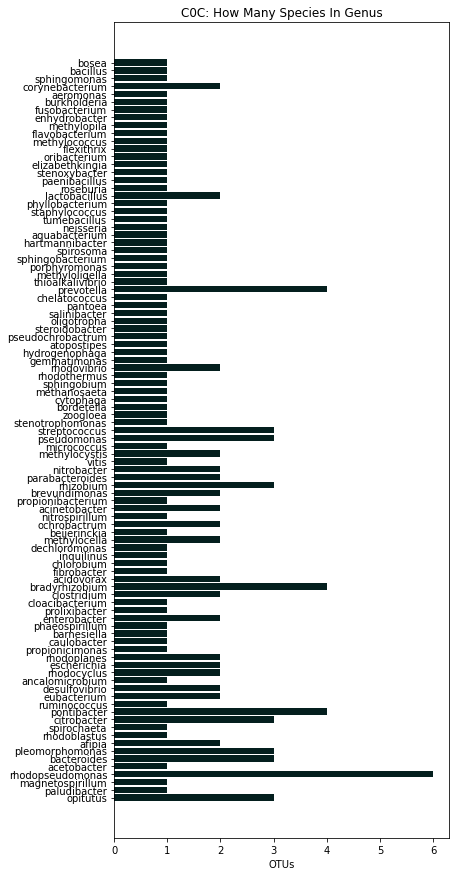

In [22]:
original = df_counts_rel.loc['C0C']
labels = original.index
genus_labels = [i.split()[0] for i in labels]
genus_count = Counter(genus_labels)

# just get a sense of how many species are in a family
f, ax = plt.subplots(figsize=(6, 15))
ax.barh(list(genus_count.keys()), list(genus_count.values()), color=def_color)
ax.set_title("C0C: How Many Species In Genus")
ax.set_xlabel("OTUs")

Text(0.5, 0, 'Absolute OTU Read Counts')

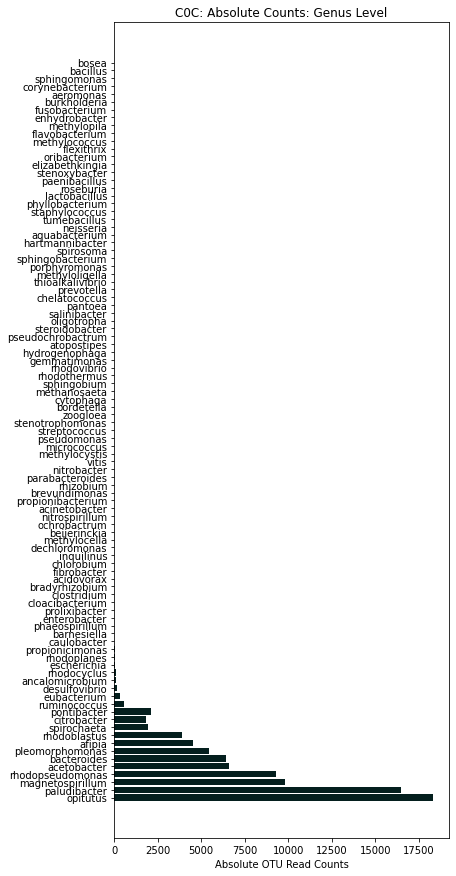

In [23]:
original = df_counts.loc['C0C']
col_mapper = {i: i.split()[0] for i in original.index}
original_by_family = original.rename(col_mapper)
original_by_family = original_by_family.groupby(level=0, sort=False).sum()

searchstring = "C0C"
f, ax = plt.subplots(figsize=(6, 15))
for sample_label in df_counts_rel.index:
    if sample_label.startswith(searchstring):
        data = original_by_family
        # set plot variables
        carbon_style = map_carbon_colors["C0C"]
        series_style = map_carbon_shapes["C0C"]
        day_style = 0
        transfer_style = None      
        ax.barh(data.index, data.values, color=def_color)
ax.set_title("{}: Absolute Counts: Genus Level".format(searchstring))
ax.set_xlabel("Absolute OTU Read Counts")

Text(0.5, 0, 'Summed Relative OTU Read Counts')

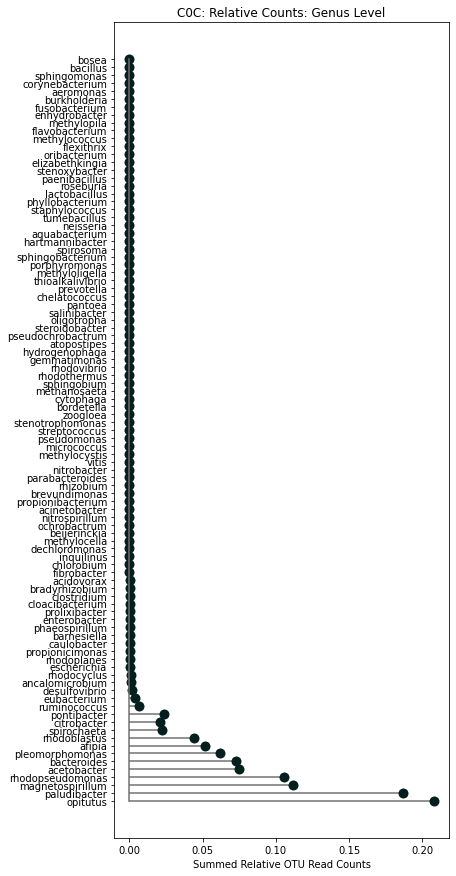

In [24]:
original = df_counts_rel.loc['C0C']
col_mapper = {i: i.split()[0] for i in original.index}
original_by_family = original.rename(col_mapper)
original_by_family = original_by_family.groupby(level=0, sort=False).sum()

searchstring = "C0C"
f, ax = plt.subplots(figsize=(6, 15))
for sample_label in df_counts_rel.index:
    if sample_label.startswith(searchstring):
        data = original_by_family
        # set plot variables
        series_style = map_carbon_colors["C0C"]
        carbon_style = map_carbon_shapes["C0C"]
        day_style = map_days_widths["C0C"]
        transfer_style = map_transfers_colors["C0C"]        
        # set plot styling
        (markerline, stemlines, baseline) = ax.stem(data.index, data.values, orientation="horizontal")
        plt.setp(markerline, markersize=def_marker_size, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
        plt.setp(stemlines, "color", def_line_color)
        plt.setp(baseline, "color", def_line_color)
#         ax.barh(data.index, data.values, color=def_color)
ax.set_title("{}: Relative Counts: Genus Level".format(searchstring))
ax.set_xlabel("Summed Relative OTU Read Counts")

### Beta Analysis

Make bar charts to:
* Observe original community
* Observe composition shift as effect of carbon perturbation
* Make sure no samples look weird

Log Scale is favorable because small fluctuations in large numbers do not matter as much

In [25]:
def rel_count_stem(df_counts_rel, df_annotations, groupstring, is_log=False):
    f, ax = plt.subplots(figsize=(6, 20))
    for sample_label in df_counts_rel.index:
        if sample_label.startswith(groupstring):
            data = df_counts_rel.loc[sample_label]
            # set plot variables
            series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
            carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
            day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
            transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
            # set plot styling
            if is_log:
                bottom = -6
            else:
                bottom = 0
            (markerline, stemlines, baseline) = ax.stem(data.index, data.values, orientation="horizontal", bottom=bottom)
            plt.setp(markerline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
            plt.setp(stemlines, "color", def_line_color)
            plt.setp(baseline, "color", def_line_color)
            if not is_log: plt.xlim([0, 1])
    
    ax.set_title("{}: Relative Counts".format(groupstring))
    if is_log:
        ax.set_xlabel("Log Transform Relative Counts")
    else: 
        ax.set_xlabel("Relative Counts")

### Original Community

Text(0.5, 0, 'Log Absolute Counts')

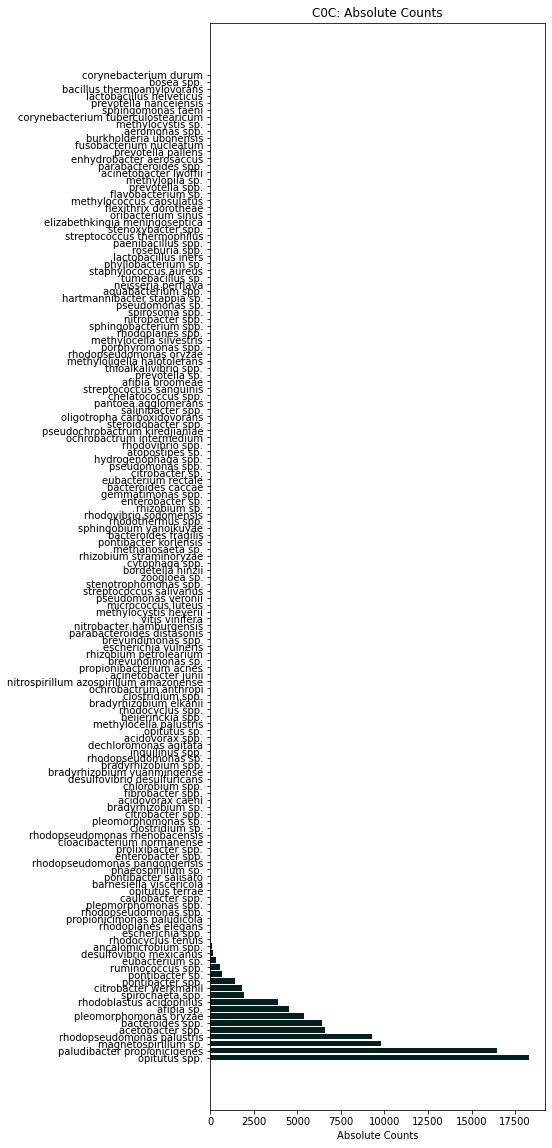

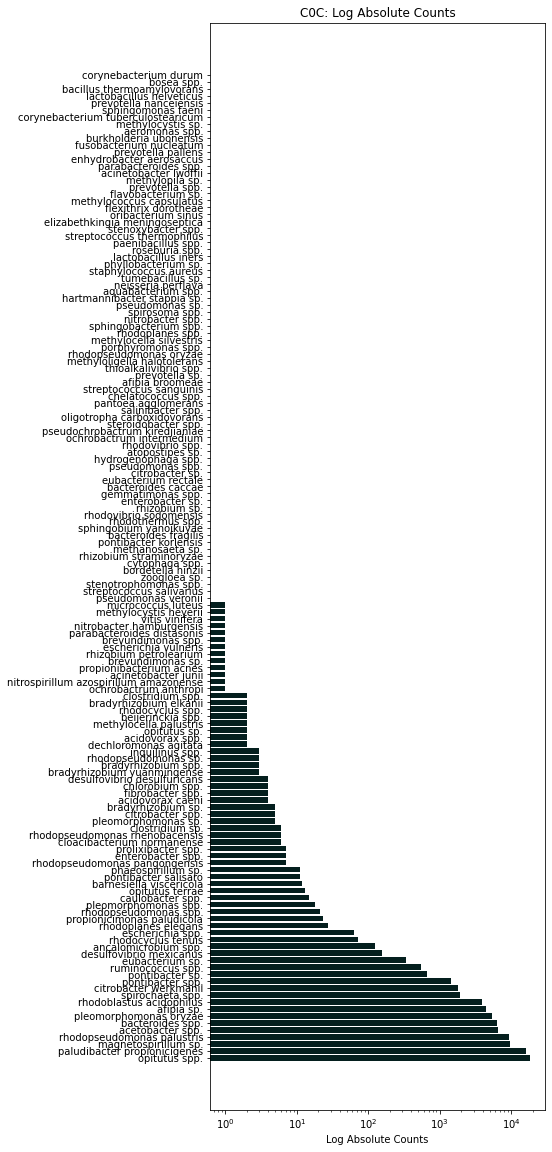

In [26]:
data = df_counts.loc['C0C']
f, ax = plt.subplots(figsize=(6, 20))
ax.barh(data.index, data.values, color=def_color)
ax.set_title("C0C: Absolute Counts")
ax.set_xlabel("Absolute Counts")

data = df_counts.loc['C0C']
f, ax = plt.subplots(figsize=(6, 20))
ax.barh(data.index, data.values, log=True, color=def_color)
ax.set_title("C0C: Log Absolute Counts")
ax.set_xlabel("Log Absolute Counts")

### Composition Shift

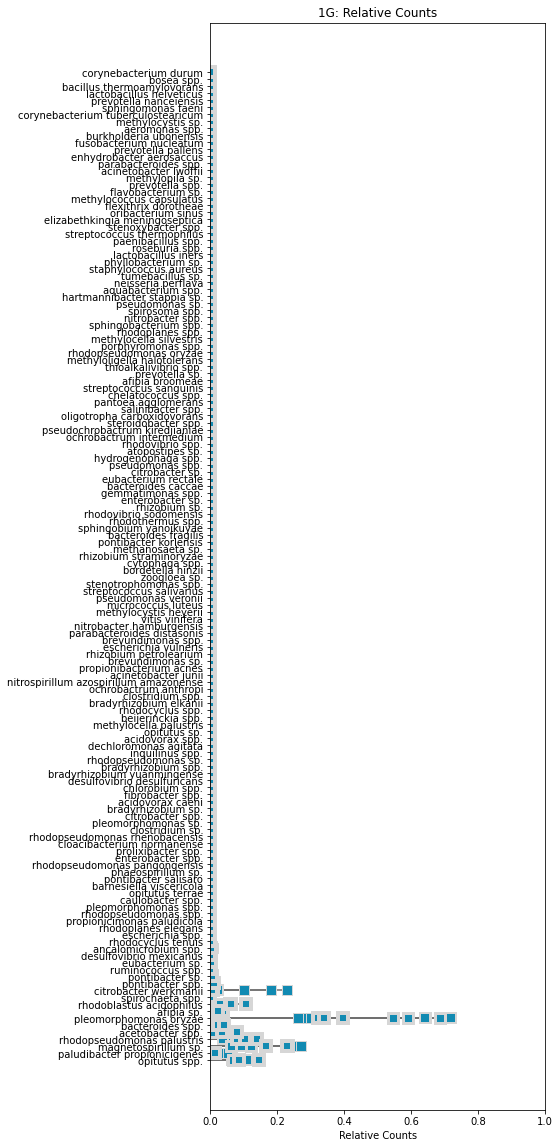

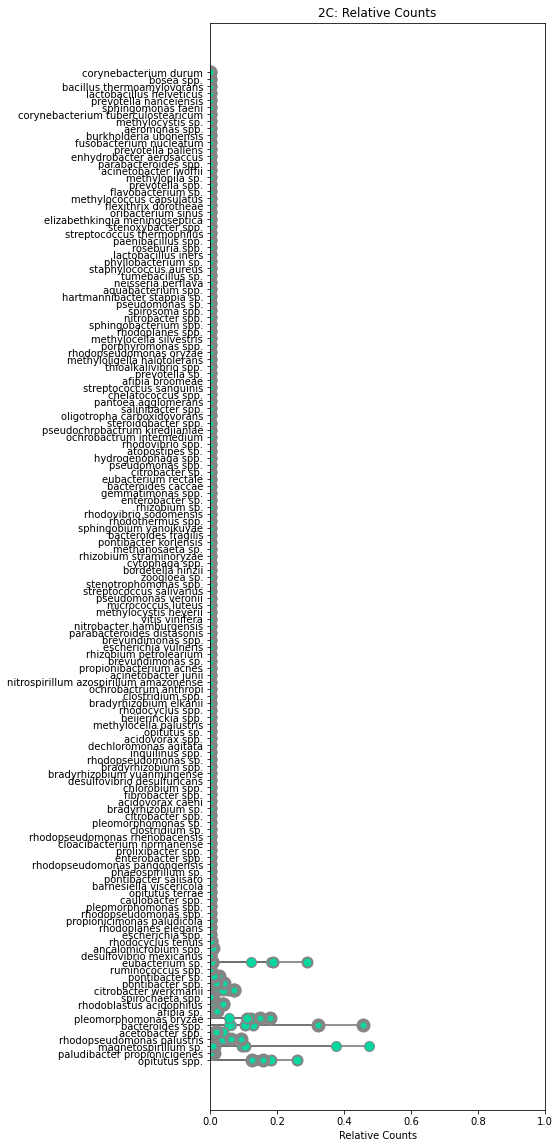

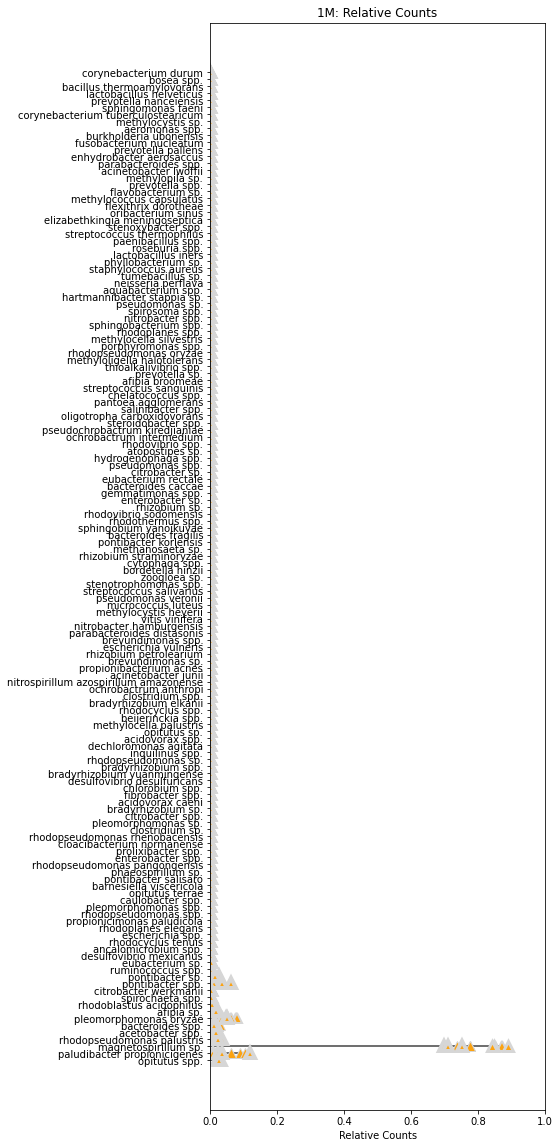

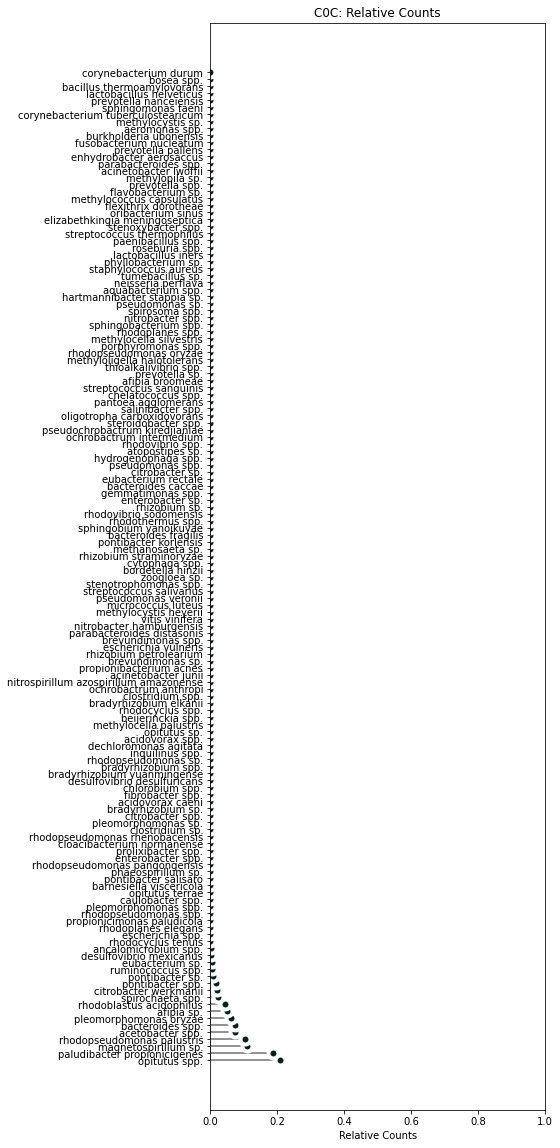

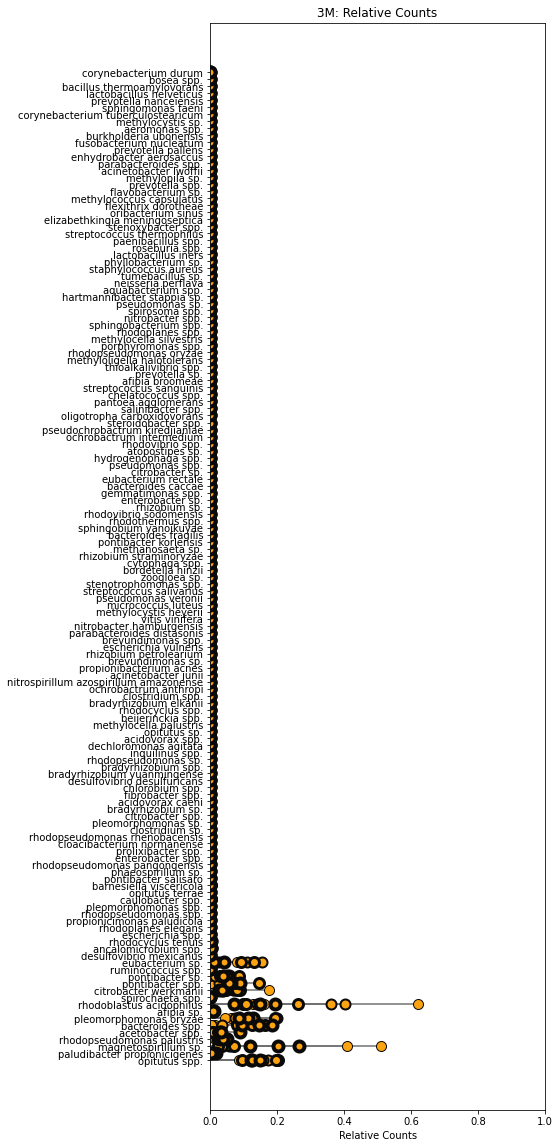

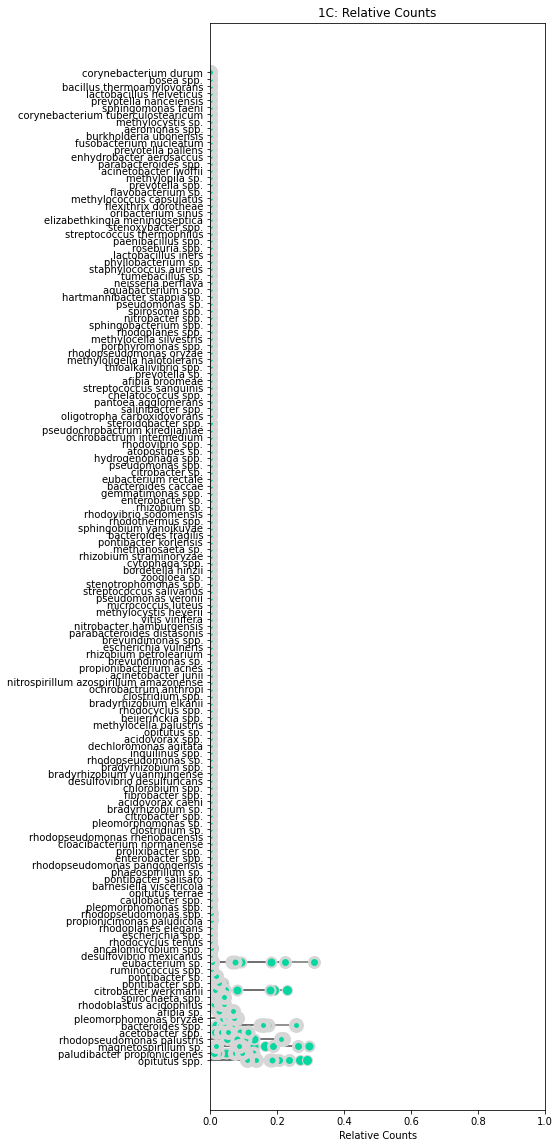

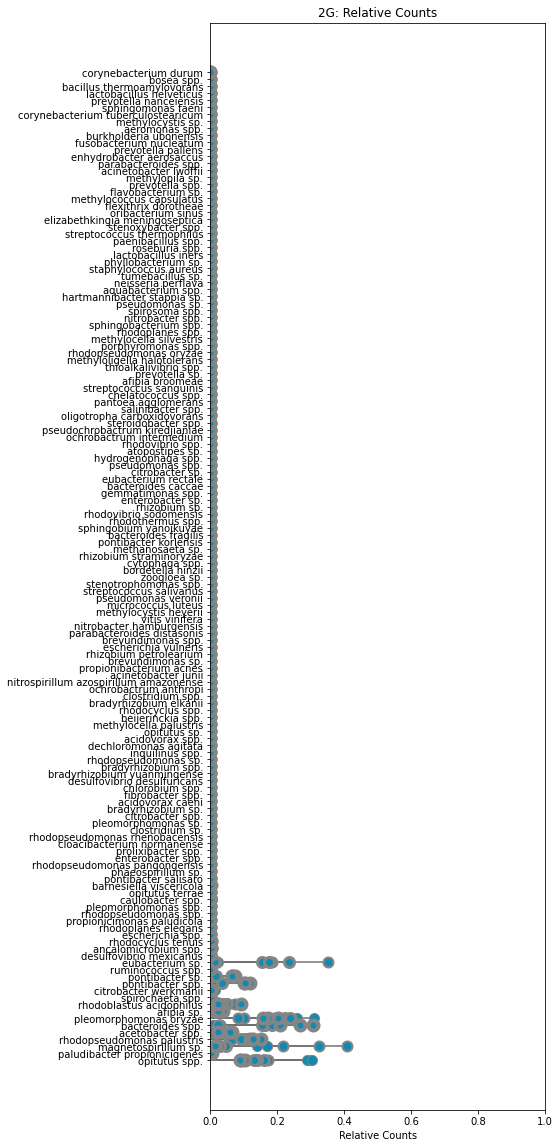

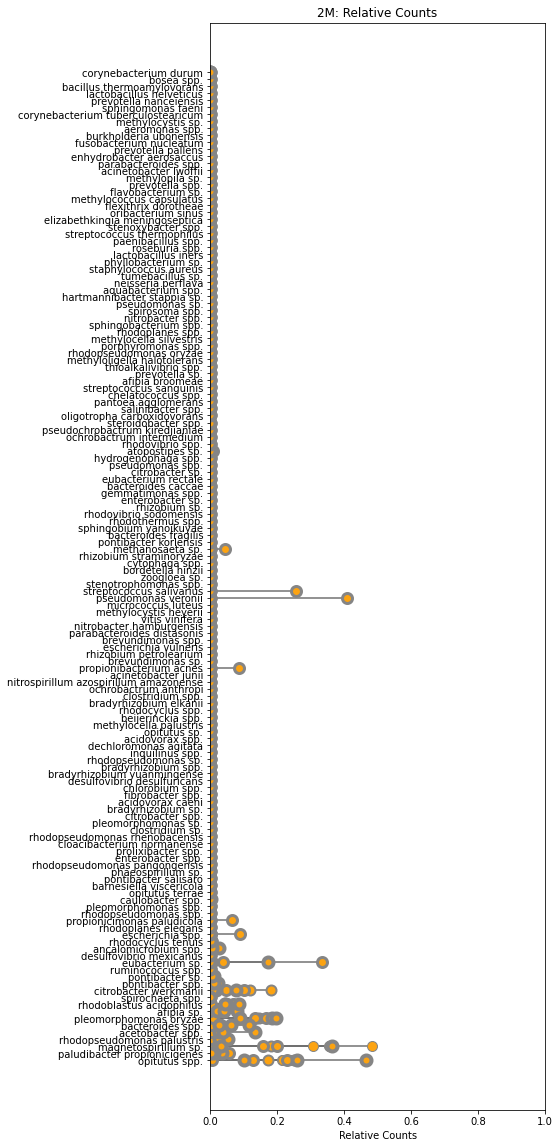

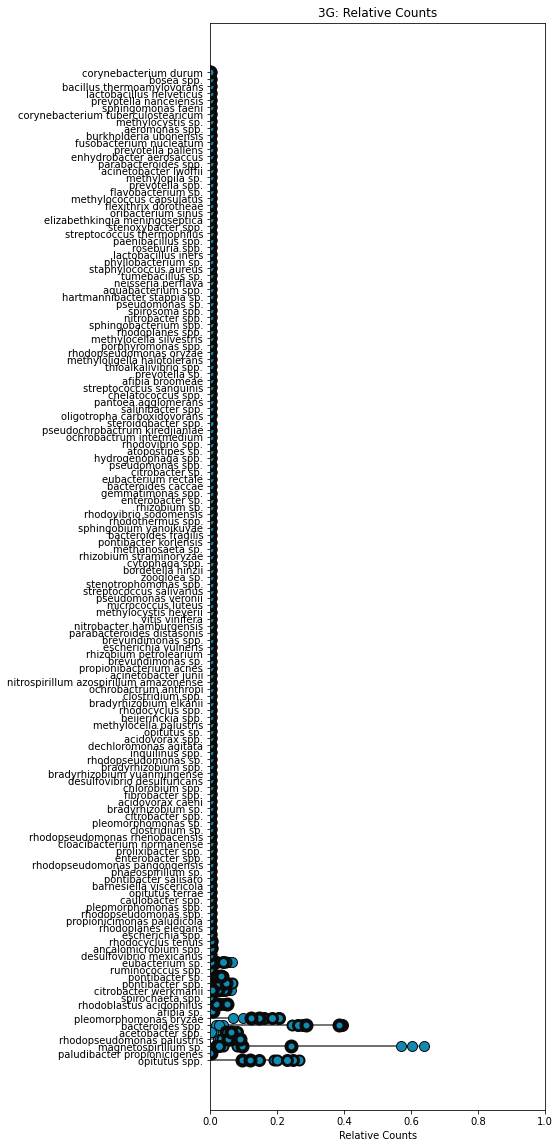

In [27]:
for g in groups:
    rel_count_stem(df_counts_rel, df_annotations, g)

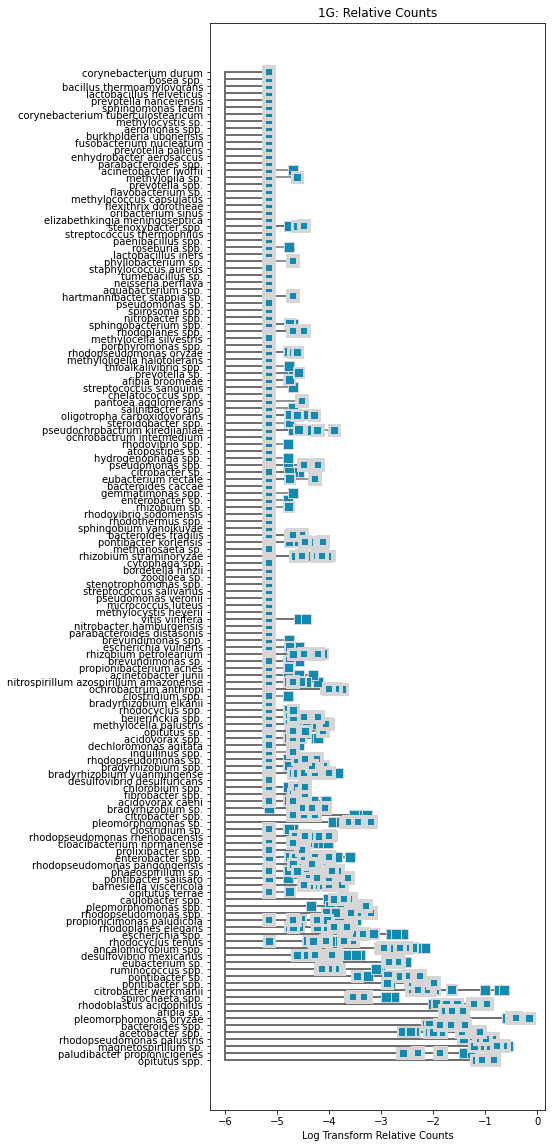

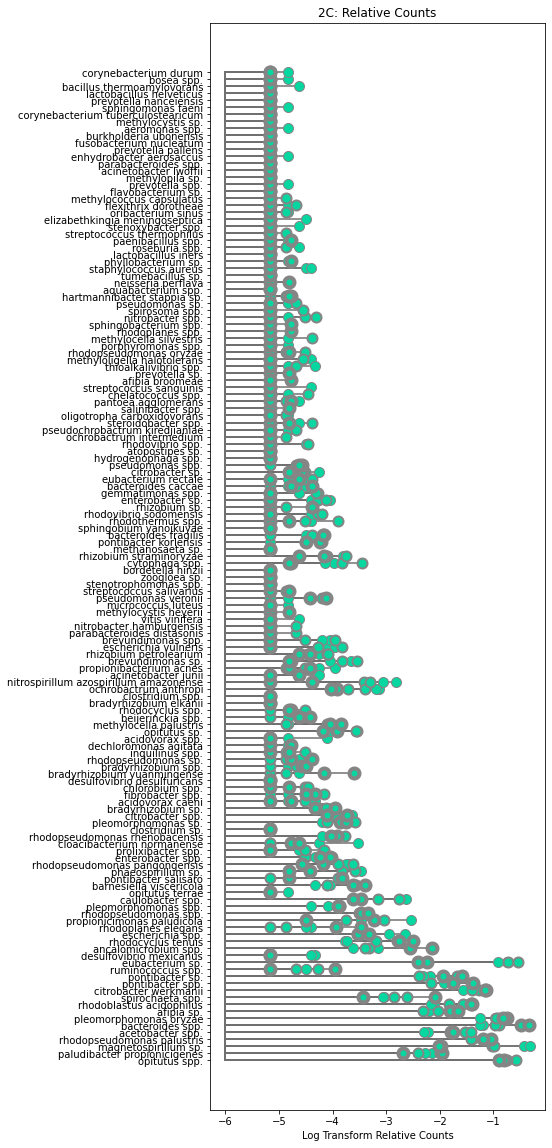

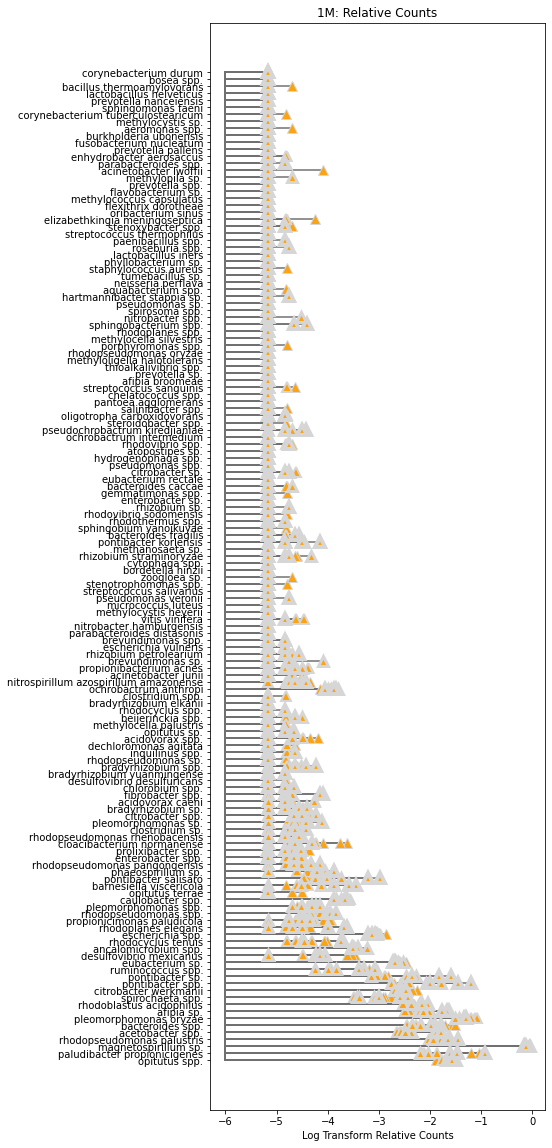

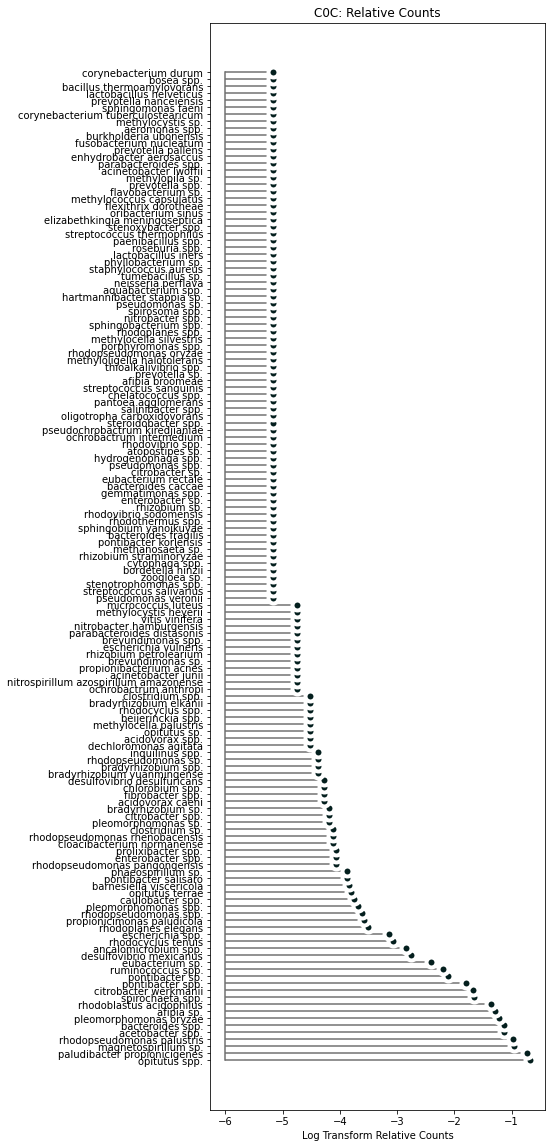

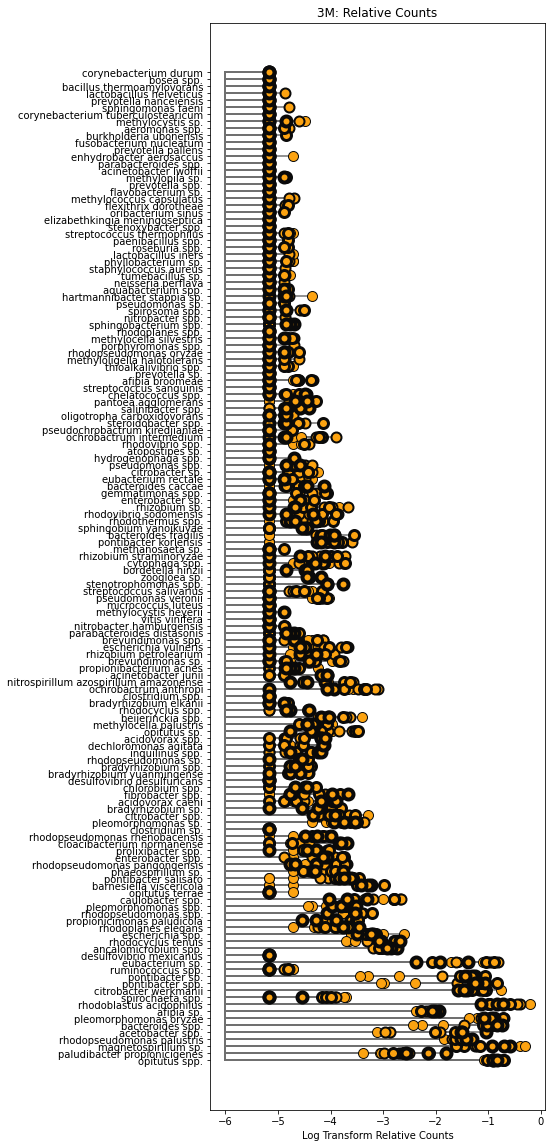

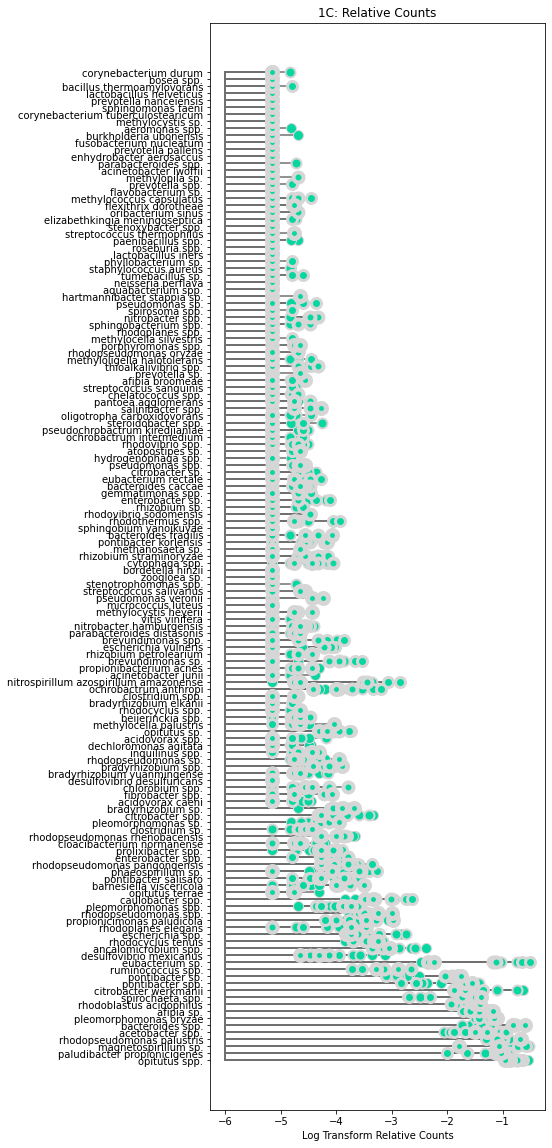

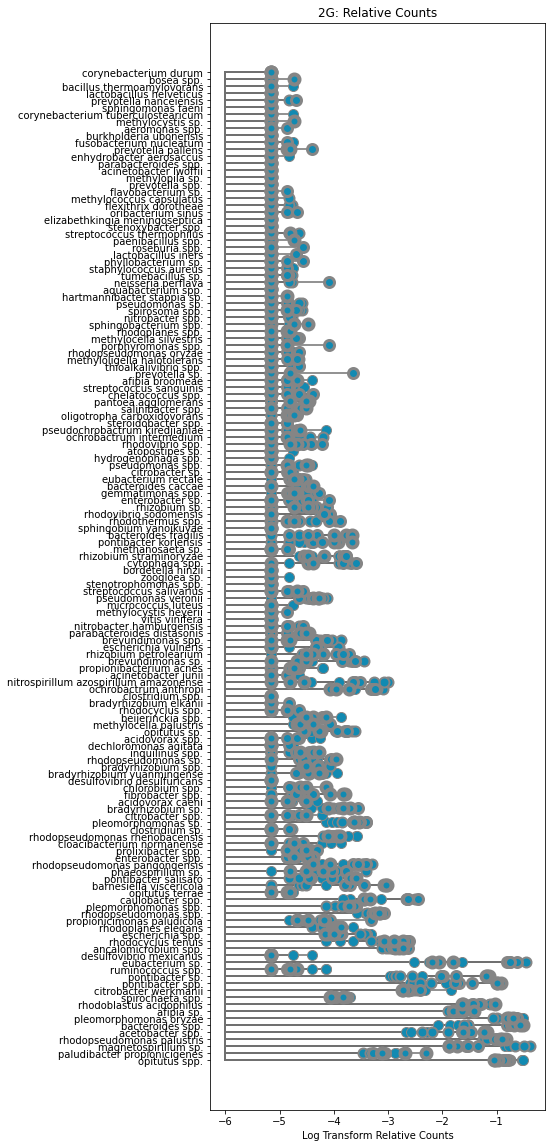

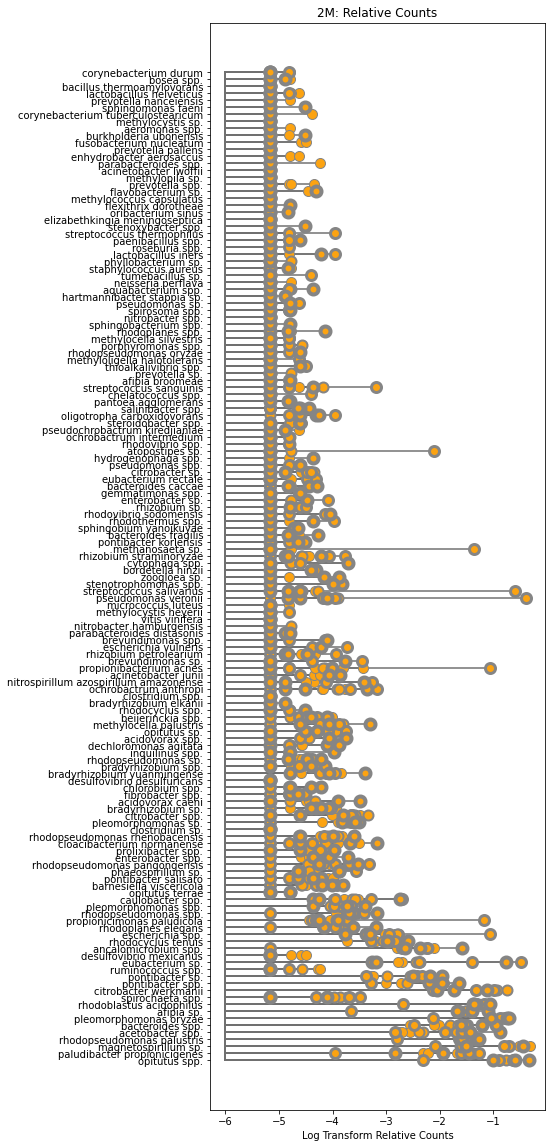

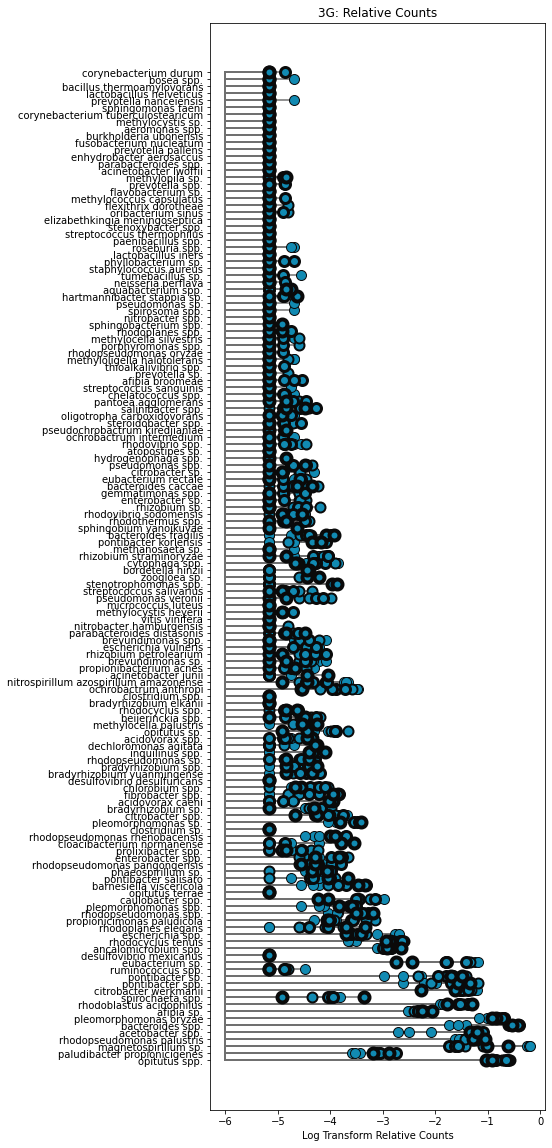

In [28]:
for g in groups:
    rel_count_stem(df_log_counts_rel, df_annotations, g, is_log=True)

### Beta-Diversity: PCoA with Bray-Curtis Distance
Mesaure differences between samples  
* compute Bray-Curtis distances, a beta diversity distance metric, between all pairs of samples
* perform principal coordinates analysis (PCoA) on the distance matrix
* see how the groups fall (color by factor)

Use Bray-Curtis dissimilarity because it is a better measure of the distance between populations. It is calculated by dividing shared abundance by total abundance. For ANOSIM statistical analysis, a positive value of r statistic indicates clustering, and the p-value is significant at an alpha of 0.1.

Ordination techniques, such as PCoA, are useful for exploratory analysis. The next step is to quantify the strength of the grouping/clustering that we see in ordination plots. There are many statistical methods available to accomplish this; many operate on distance matrices. Let’s use ANOSIM to quantify the strength of the clustering we see in the ordination plots above, using the Bray-Curtis distance matrix and sample metadata.

From the PCoA plots, we can see the clustering of carbon source glucose and carbon source malate. There is also an interesting trend where the left side of the cellulose cluster is from smaller days, and the right side of the cellulose cluster is from larger days, maybe indicating the presence of a transition state? Maybe some bacteria do not transfer well and need a few days to recover?

*Sources:*  
scikit-bio tutorial

In [29]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

TODO: Make PCoA plots, growing on cellulose, growing on cellulose, growing on malate  
TODO: Cellulose-only PCoA plot
TODO: Put percent variance explained by each axis

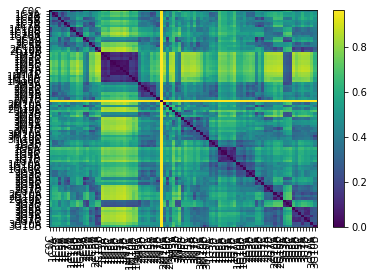

In [30]:
bc_dm = beta_diversity("braycurtis", df_counts_rel.values, df_counts_rel.index)
bc_dm

In [31]:
bc_pc = pcoa(bc_dm)
bc_pc_cum_sum = bc_pc.eigvals / bc_pc.eigvals.sum()

num_comp = 2
print(num_comp, "Components Cummulative Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))
num_comp = 3
print(num_comp, "Components Cummulative Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))

2 Components Cummulative Explained Variance: 0.5215032051668631
3 Components Cummulative Explained Variance: 0.6217975173850055


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.173529666822175 and the largest is 5.698667734722999.
  warn(


In [32]:
bc_pc.samples

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
C0C    0.118670 -0.041077  0.003794 -0.211743 -0.146310 -0.070743 -0.137396   
1C3A  -0.006877  0.026753  0.170209 -0.210793 -0.231347  0.006931 -0.011808   
1C3B   0.013110  0.034578  0.181184 -0.212393 -0.251975 -0.006348 -0.001010   
1C5A  -0.084984 -0.093903  0.215429 -0.126298  0.032305 -0.090033  0.032095   
1C5B   0.076463 -0.069242  0.150654 -0.150771 -0.112932 -0.058030 -0.088910   
...         ...       ...       ...       ...       ...       ...       ...   
3G7A   0.304101 -0.088383 -0.194287  0.020351  0.021793  0.059397  0.072736   
3G7B   0.311718 -0.032304 -0.102869 -0.023308 -0.038661  0.061103  0.129723   
3G7C   0.304461 -0.070234 -0.072265 -0.025989 -0.020492  0.045702  0.119868   
3G10A  0.220663 -0.019902 -0.218870 -0.028266  0.036176  0.058040  0.009899   
3G10B  0.067100 -0.068642 -0.199084 -0.059265  0.080175  0.094225  0.053070   

            PC8       PC9      PC10  ...  PC78  PC79  PC80  PC81  PC82  PC83  \
C0C    0.115718 -0.024352  0.063912  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C3A  -0.055121  0.017740 -0.036550  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C3B  -0.052261  0.039171 -0.025262  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C5A  -0.064461 -0.001000 -0.063057  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1C5B  -0.123050  0.086399 -0.029164  ...   0.0   0.0   0.0   0.0   0.0   0.0   
...         ...       ...       ...  ...   ...   ...   ...   ...   ...   ...   
3G7A   0.024222  0.035023 -0.051840  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G7B   0.106102  0.007669  0.002980  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G7C   0.092583  0.030919 -0.003917  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G10A -0.007226  0.032937 -0.053725  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3G10B -0.034672  0.003293 -0.004373  ...   0.0   0.0   0.0   0.0   0.0   0.0   

       PC84  PC85  PC86  PC87  
C0C     0.0   0.0   0.0   0.0  
1C3A    0.0   0.0   0.0   0.0  
1C3B    0.0   0.0   0.0   0.0  
1C5A    0.0   0.0   0.0   0.0  
1C5B    0.0   0.0   0.0   0.0  
...     ...   ...   ...   ...  
3G7A    0.0   0.0   0.0   0.0  
3G7B    0.0   0.0   0.0   0.0  
3G7C    0.0   0.0   0.0   0.0  
3G10A   0.0   0.0   0.0   0.0  
3G10B   0.0   0.0   0.0   0.0  

[87 rows x 87 columns]

In [33]:
from skbio.stats.distance import anosim

In [34]:
results = anosim(bc_dm, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])                                                                                                                                

carbon clustering 0.5469602481819956
	 p-value 0.001
day clustering 0.13220926402959443
	 p-value 0.001
transfer clustering 0.1635819769672457
	 p-value 0.001


Text(0, 0.5, 'PC 2 (0.13% explained variance)')

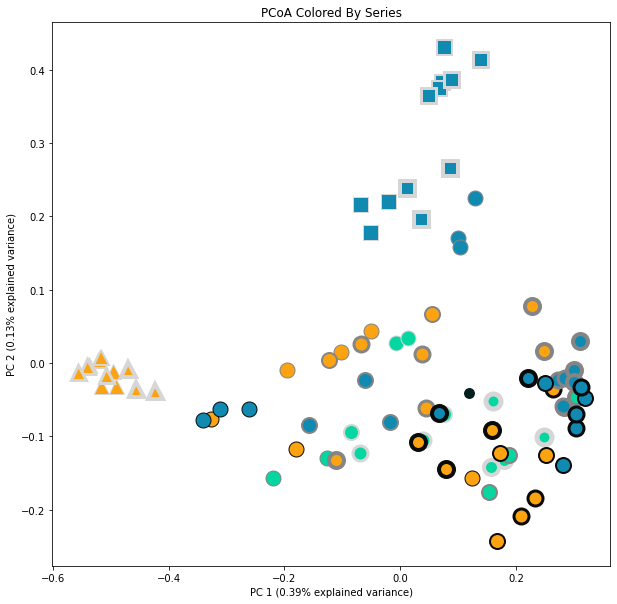

In [35]:
f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")

Text(0, 0.5, 'PC 2 (0.13% explained variance)')

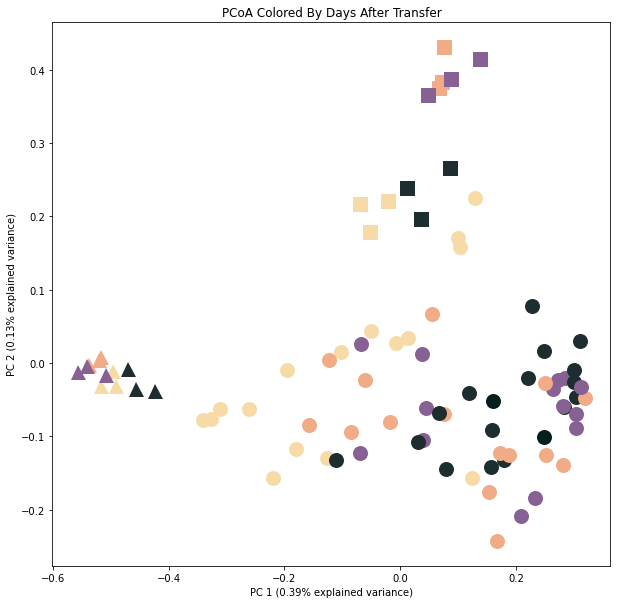

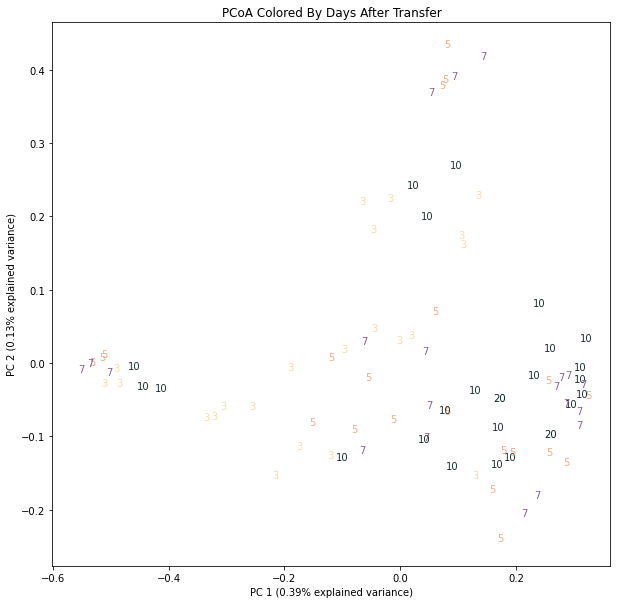

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=15, color=day_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=0)
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")

f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=15, color="white", marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=0)
    ax.annotate(df_annotations.loc[sample_label, "day"], (data["PC1"], data["PC2"]), color=day_style)
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")

Text(0.5, 0, 'PC 3 (0.1% explained variance)')

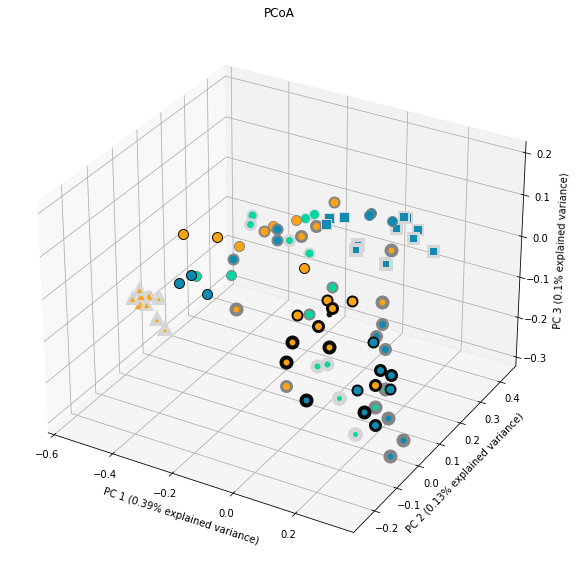

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc.eigvals[2] / bc_pc.eigvals.sum(), 2)}% explained variance)")

Text(0.5, 0, 'PC 3 (0.1% explained variance)')

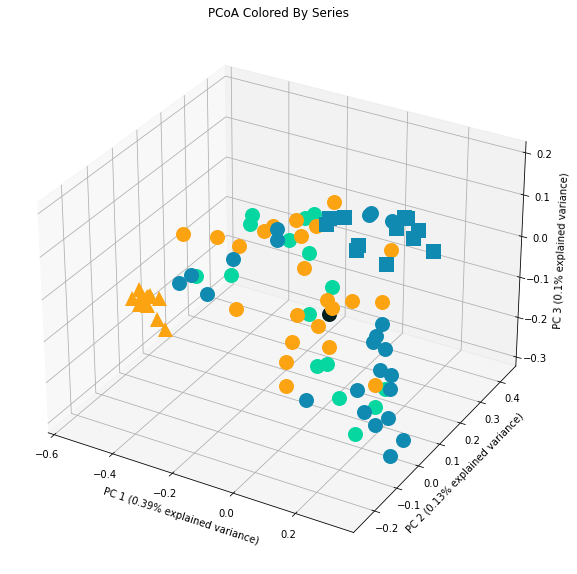

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc.eigvals[2] / bc_pc.eigvals.sum(), 2)}% explained variance)")

Text(0.5, 0, 'PC 3 (0.1% explained variance)')

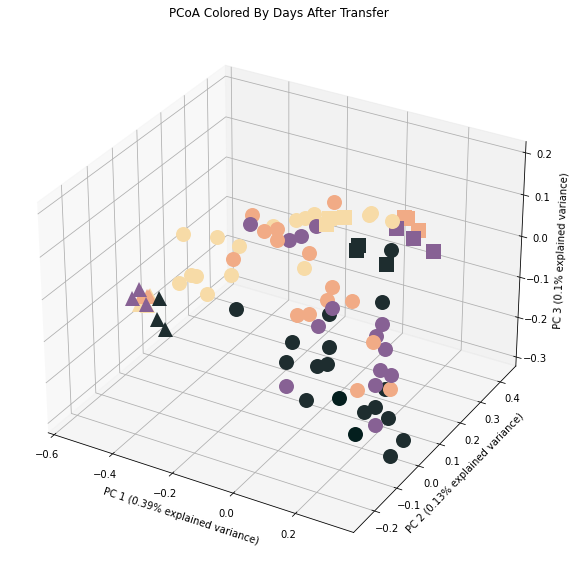

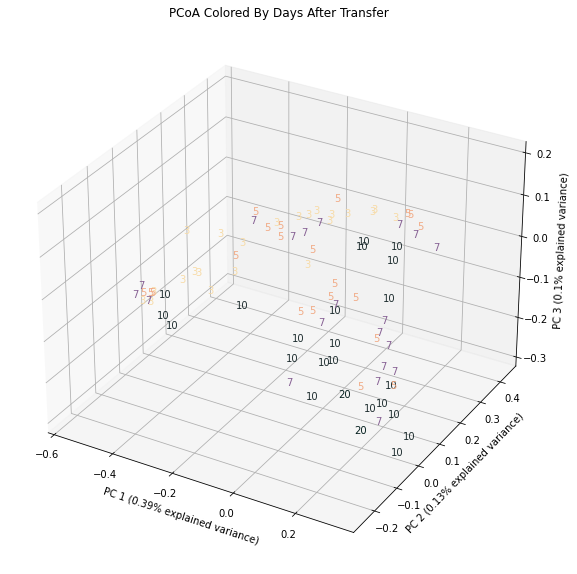

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=day_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc.eigvals[2] / bc_pc.eigvals.sum(), 2)}% explained variance)")


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=0, color="white", marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
    ax.text(data["PC1"], data["PC2"], data["PC3"], df_annotations.loc[sample_label, "day"], size=10, zorder=1, color=day_style) 
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc.eigvals[2] / bc_pc.eigvals.sum(), 2)}% explained variance)")

Text(0.5, 0, 'PC 3 (0.1% explained variance)')

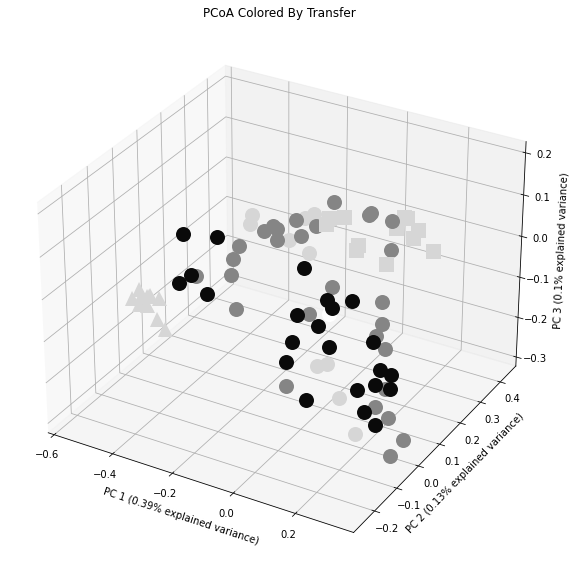

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=transfer_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Transfer")
ax.set_xlabel(f"PC 1 ({round(bc_pc.eigvals[0] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc.eigvals[1] / bc_pc.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc.eigvals[2] / bc_pc.eigvals.sum(), 2)}% explained variance)")

## Make PCoA Plots of Only Cellulose

Groups:
'1C', '1G', '1M', '2C', '2G', '2M', '3G', '3M'

In [41]:
# make list of samples to include (samples currently using cellulose carbon source)
only_cell_index = []
for sample_label in df_counts_rel.index:
    if (df_annotations.loc[sample_label, "group"] == '1G' or df_annotations.loc[sample_label, "group"] == '1M'):
        continue
    only_cell_index.append(sample_label)

print(only_cell_index)
    
df_counts_rel_only_cell = df_counts_rel.loc[only_cell_index, :]
bc_dm_only_cell = beta_diversity("braycurtis", df_counts_rel_only_cell.values, df_counts_rel_only_cell.index)
bc_pc_only_cell = pcoa(bc_dm_only_cell)

['C0C', '1C3A', '1C3B', '1C5A', '1C5B', '1C7A', '1C7B', '1C10A', '1C10B', '1C20B', '1C20A', '2C3A', '2C3B', '2C5A', '2C5B', '2C10A', '2C10B', '2M3A', '2M3B', '2M3C', '2M5A', '2M5B', '2M7A', '2M7B', '2M7C', '2M10A', '2M10B', '2M10C', '3M3A', '3M3B', '3M3C', '3M5B', '3M5C', '3M5A', '3M7A', '3M7B', '3M7C', '3M10A', '3M10B', '3M10C', '2G3A', '2G3B', '2G3C', '2G5A', '2G5B', '2G5C', '2G7A', '2G7B', '2G7C', '2G10A', '2G10B', '2G10C', '3G3A', '3G3B', '3G3C', '3G5A', '3G5B', '3G5C', '3G7A', '3G7B', '3G7C', '3G10A', '3G10B']


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.15200868001413287 and the largest is 2.5514385006304416.
  warn(


In [42]:
# statistical analysis
results = anosim(bc_dm_only_cell, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_cell, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm_only_cell, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])        

carbon clustering 0.05177325531806017
	 p-value 0.355
day clustering 0.2733527348254772
	 p-value 0.001
transfer clustering 0.15896125991702467
	 p-value 0.001


Text(0, 0.5, 'PC 2 (0.12% explained variance)')

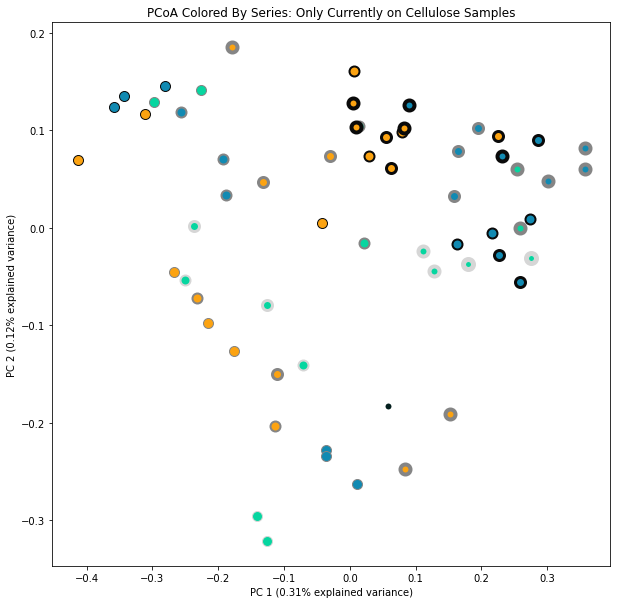

In [43]:
f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel_only_cell.index:
    data = bc_pc_only_cell.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

Text(0.5, 0, 'PC 3 (0.11% explained variance)')

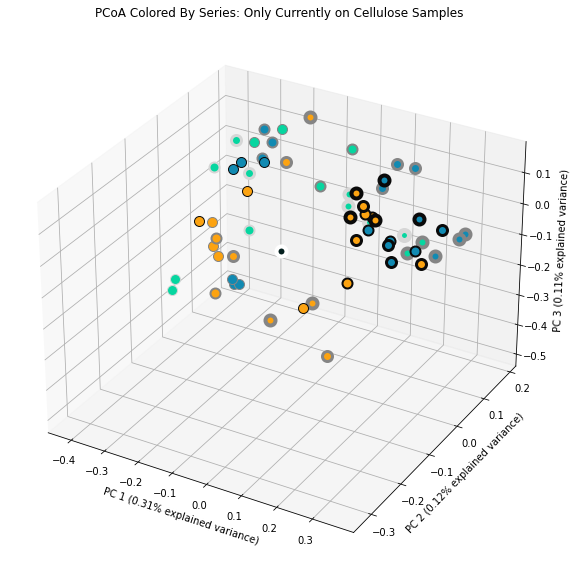

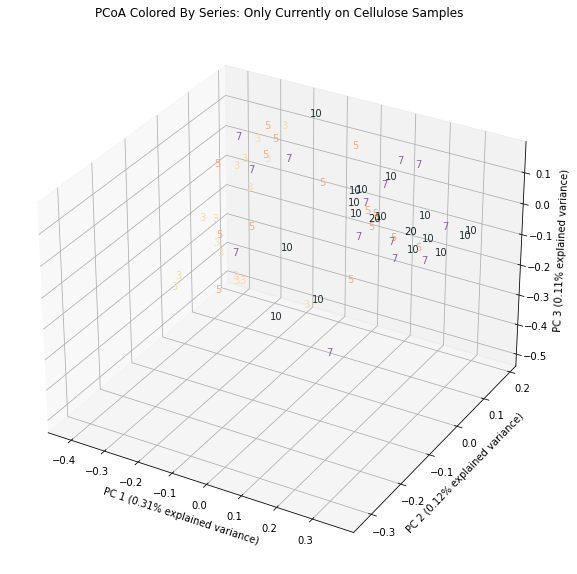

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel_only_cell.index:
    data = bc_pc_only_cell.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for sample_label in df_counts_rel_only_cell.index:
    data = bc_pc_only_cell.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=0, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
    ax.text(data["PC1"], data["PC2"], data["PC3"], df_annotations.loc[sample_label, "day"], size=10, zorder=1, color=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

num_points: 17


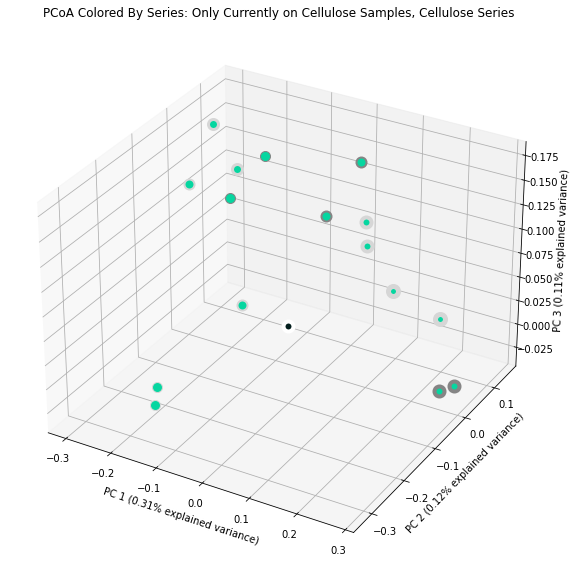

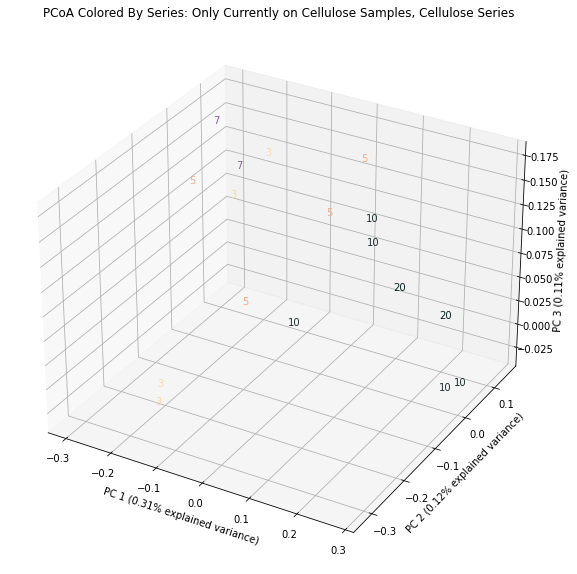

In [45]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
num_points = 0
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "C" or sample_label == "C0C":
        num_points += 1
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Cellulose Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "C" or sample_label == "C0C":
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=0, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
        ax.text(data["PC1"], data["PC2"], data["PC3"], df_annotations.loc[sample_label, "day"], size=10, zorder=1, color=day_style) 
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Cellulose Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

print("num_points:", num_points)

num_points: 24


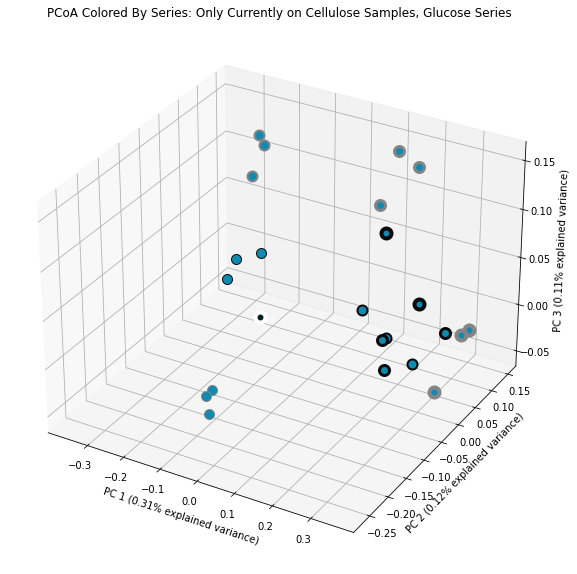

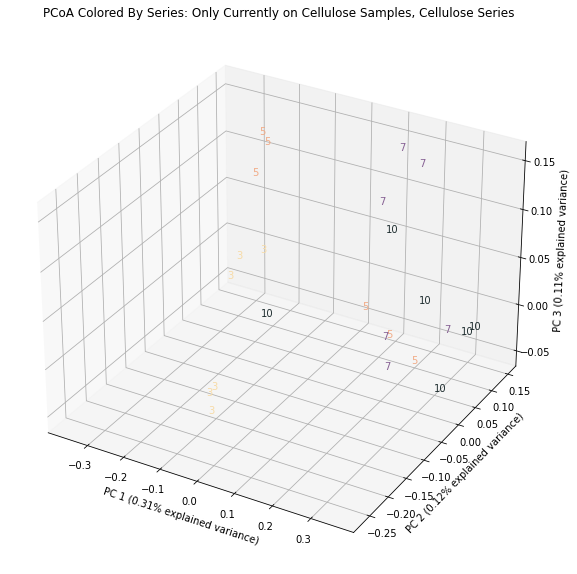

In [46]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
num_points = 0
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "G" or sample_label == "C0C":
        num_points += 1
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Glucose Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "G" or sample_label == "C0C":
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=0, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
        ax.text(data["PC1"], data["PC2"], data["PC3"], df_annotations.loc[sample_label, "day"], size=10, zorder=1, color=day_style) 
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Cellulose Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

print("num_points:", num_points)

num_points: 24


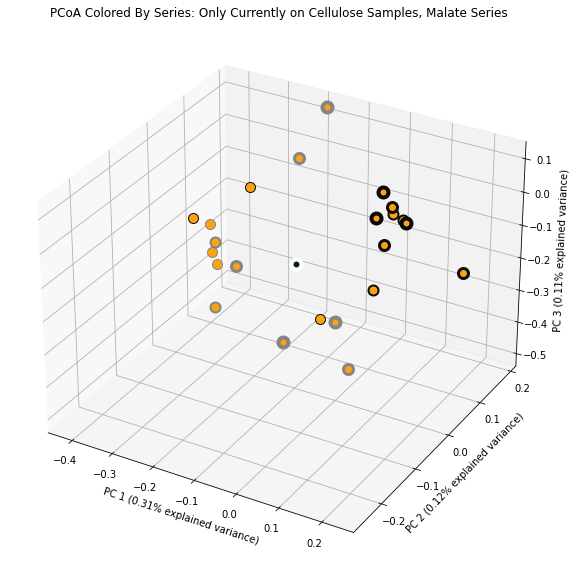

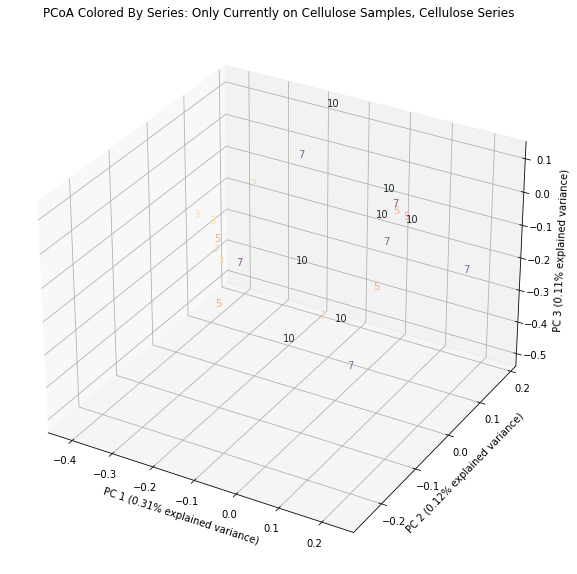

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
num_points = 0
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "M" or sample_label == "C0C":
        num_points += 1
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=10, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Malate Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for sample_label in df_counts_rel_only_cell.index:
    if df_annotations.loc[sample_label, "series"] == "M" or sample_label == "C0C":
        data = bc_pc_only_cell.samples.loc[sample_label]
        # set plot variables
        carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
        day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
        transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]
        # set plot styling
        plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
        plt.setp(plotline, markersize=0, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
        ax.text(data["PC1"], data["PC2"], data["PC3"], df_annotations.loc[sample_label, "day"], size=10, zorder=1, color=day_style) 
ax.set_title("PCoA Colored By Series: Only Currently on Cellulose Samples, Cellulose Series")
ax.set_xlabel(f"PC 1 ({round(bc_pc_only_cell.eigvals[0] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_ylabel(f"PC 2 ({round(bc_pc_only_cell.eigvals[1] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")
ax.set_zlabel(f"PC 3 ({round(bc_pc_only_cell.eigvals[2] / bc_pc_only_cell.eigvals.sum(), 2)}% explained variance)")


print("num_points:", num_points)